# Embeddings

This section is based on TensorFlow's [Word2Vec tutorial](https://www.tensorflow.org/versions/r0.11/tutorials/word2vec/index.html).

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.show()
# Where to save the figures
PROJECT_ROOT_DIR = "E:\\CLASSES\\Code\\dl\\codedl08"
CHAPTER_ID = "rnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [2]:
import tensorflow as tf
tf.__version__

/usr/lib64/python3.4/importlib/_bootstrap.py:321: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return f(*args, **kwds)


'1.5.0'

## Fetch the data

In [3]:
from six.moves import urllib

import errno
import os
import zipfile

WORDS_PATH = "datasets/words"
WORDS_URL = 'http://mattmahoney.net/dc/text8.zip'

def mkdir_p(path):
    """Create directories, ok if they already exist.
    
    This is for python 2 support. In python >=3.2, simply use:
    >>> os.makedirs(path, exist_ok=True)
    """
    try:
        os.makedirs(path)
    except OSError as exc:
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

def fetch_words_data(words_url=WORDS_URL, words_path=WORDS_PATH):
    os.makedirs(words_path, exist_ok=True)
    zip_path = os.path.join(words_path, "words.zip")
    if not os.path.exists(zip_path):
        urllib.request.urlretrieve(words_url, zip_path)
    with zipfile.ZipFile(zip_path) as f:
        data = f.read(f.namelist()[0])
    return data.decode("ascii").split()

In [4]:
words = fetch_words_data()

In [5]:
words[:5]

['anarchism', 'originated', 'as', 'a', 'term']

## Build the dictionary

In [6]:
from collections import Counter
import numpy as np
vocabulary_size = 50000

vocabulary = [("UNK", None)] + Counter(words).most_common(vocabulary_size - 1)
vocabulary = np.array([word for word, _ in vocabulary])
dictionary = {word: code for code, word in enumerate(vocabulary)}
data = np.array([dictionary.get(word, 0) for word in words])

In [7]:
" ".join(words[:9]), data[:9]

('anarchism originated as a term of abuse first used',
 array([5237, 3082,   12,    6,  195,    2, 3134,   46,   59]))

In [8]:
" ".join([vocabulary[word_index] for word_index in [5241, 3081, 12, 6, 195, 2, 3134, 46, 59]])

'default inducted as a term of abuse first used'

In [9]:
words[24], data[24]

('culottes', 0)

## Generate batches

In [10]:
import random
from collections import deque

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

In [11]:
data_index=0
batch, labels = generate_batch(8, 2, 1)

In [12]:
batch, [vocabulary[word] for word in batch]

(array([3082, 3082,   12,   12,    6,    6,  195,  195], dtype=int32),
 ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term'])

In [13]:
labels, [vocabulary[word] for word in labels[:, 0]]

(array([[5237],
        [  12],
        [3082],
        [   6],
        [ 195],
        [  12],
        [   6],
        [   2]], dtype=int32),
 ['anarchism', 'as', 'originated', 'a', 'term', 'as', 'a', 'of'])

## Build the model

In [14]:
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.

learning_rate = 0.01

In [15]:
reset_graph()

# Input data.
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

In [16]:
vocabulary_size = 50000
embedding_size = 150

# Look up embeddings for inputs.
init_embeds = tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)
embeddings = tf.Variable(init_embeds)

In [17]:
train_inputs = tf.placeholder(tf.int32, shape=[None])
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

In [18]:
# Construct the variables for the NCE loss
nce_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                        stddev=1.0 / np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

# Compute the average NCE loss for the batch.
# tf.nce_loss automatically draws a new sample of the negative labels each
# time we evaluate the loss.
loss = tf.reduce_mean(
    tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed,
                   num_sampled, vocabulary_size))

# Construct the Adam optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

# Compute the cosine similarity between minibatch examples and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

# Add variable initializer.
init = tf.global_variables_initializer()

Instructions for updating:
keep_dims is deprecated, use keepdims instead


## Train the model

In [19]:
num_steps = 10001

with tf.Session() as session:
    init.run()

    average_loss = 0
    for step in range(num_steps):
        print("\rIteration: {}".format(step), end="\t")
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

        # We perform one update step by evaluating the training op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([training_op, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = vocabulary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log_str = "Nearest to %s:" % valid_word
                for k in range(top_k):
                    close_word = vocabulary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)

    final_embeddings = normalized_embeddings.eval()

Iteration: 0	Average loss at step  0 :  285.7776794433594
Nearest to they: wiser, collaborators, avenger, unclean, xvii, damping, willingly, elwood,
Nearest to however: increasingly, macintosh, wishbone, scarring, lacks, pes, pupils, tubulin,
Nearest to he: hurdle, cafeteria, ingersoll, damian, groupoid, iss, inheritance, waterproof,
Nearest to than: commitments, abnormal, brazilian, rosters, lineage, hamitic, enthusiastically, polski,
Nearest to so: astrologers, inasmuch, taro, chabad, destinations, susceptibility, edsger, mondial,
Nearest to for: moulin, comes, bashar, semitism, handbuch, derogatory, dandy, sprinkled,
Nearest to while: serotonin, fawn, yoko, explosively, discontent, firestone, harpers, telecom,
Nearest to if: honour, departures, conquers, compel, woodcuts, remarkably, varnish, gustav,
Nearest to after: barbed, fulton, champ, character, carpenter, cta, bogged, circuitry,
Nearest to has: donating, moog, currency, transferring, doha, monologues, apiaceae, hbox,
Nearest 

Let's save the final embeddings (of course you can use a TensorFlow `Saver` if you prefer):

In [20]:
np.save("./my_final_embeddings.npy", final_embeddings)

In [21]:
final_embeddings.shape

(50000, 150)

In [22]:
import pandas as pd
embed_df=pd.DataFrame(final_embeddings)
embed_df['name']=vocabulary

In [23]:
embed_df['name']=='woman'

0        False
1        False
2        False
3        False
4        False
5        False
6        False
7        False
8        False
9        False
10       False
11       False
12       False
13       False
14       False
15       False
16       False
17       False
18       False
19       False
20       False
21       False
22       False
23       False
24       False
25       False
26       False
27       False
28       False
29       False
         ...  
49970    False
49971    False
49972    False
49973    False
49974    False
49975    False
49976    False
49977    False
49978    False
49979    False
49980    False
49981    False
49982    False
49983    False
49984    False
49985    False
49986    False
49987    False
49988    False
49989    False
49990    False
49991    False
49992    False
49993    False
49994    False
49995    False
49996    False
49997    False
49998    False
49999    False
Name: name, Length: 50000, dtype: bool

In [24]:
embed_df[embed_df['name']=='woman']

,0,1,2,3,4,5,6,7,8,9,...,141,142,143,144,145,146,147,148,149,name
1014,0.091785,-0.019066,-0.049763,-0.172162,0.069707,-0.11314,-0.036599,-0.061379,0.09199,0.089974,...,-0.140899,0.211975,-0.08704,0.162045,0.060232,0.043614,0.007828,0.062239,-0.002001,woman


In [25]:
embed_df[embed_df['name']=='man']

,0,1,2,3,4,5,6,7,8,9,...,141,142,143,144,145,146,147,148,149,name
243,-0.014044,0.090151,-0.023305,-0.103514,-0.035119,-0.011858,0.067961,0.053654,0.105958,0.117024,...,0.080917,0.023465,0.093009,-0.054748,0.020851,0.011348,0.103623,0.008794,-0.027626,man


In [26]:
embed_df[embed_df['name']=='king']

,0,1,2,3,4,5,6,7,8,9,...,141,142,143,144,145,146,147,148,149,name
187,-0.03757,-0.175625,-0.152183,-0.041968,0.09333,-0.13286,-0.079336,0.142123,0.01622,0.04411,...,-0.028946,0.119299,0.045031,0.02626,-0.005244,0.018494,0.220697,0.025214,-0.065082,king


In [27]:
embed_df[embed_df['name']=='queen']

,0,1,2,3,4,5,6,7,8,9,...,141,142,143,144,145,146,147,148,149,name
903,-0.049518,0.007837,0.052302,-0.028669,0.084137,0.039619,-0.087044,0.121209,0.079918,0.03274,...,0.006188,0.053,0.106474,0.065788,0.060702,0.166614,0.05543,-0.017012,-0.026562,queen


In [28]:
embed_df.to_csv('./my_final_embeddings_data_frame.csv', index=False, header=False)

## Plot the embeddings

In [45]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(10, 10))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

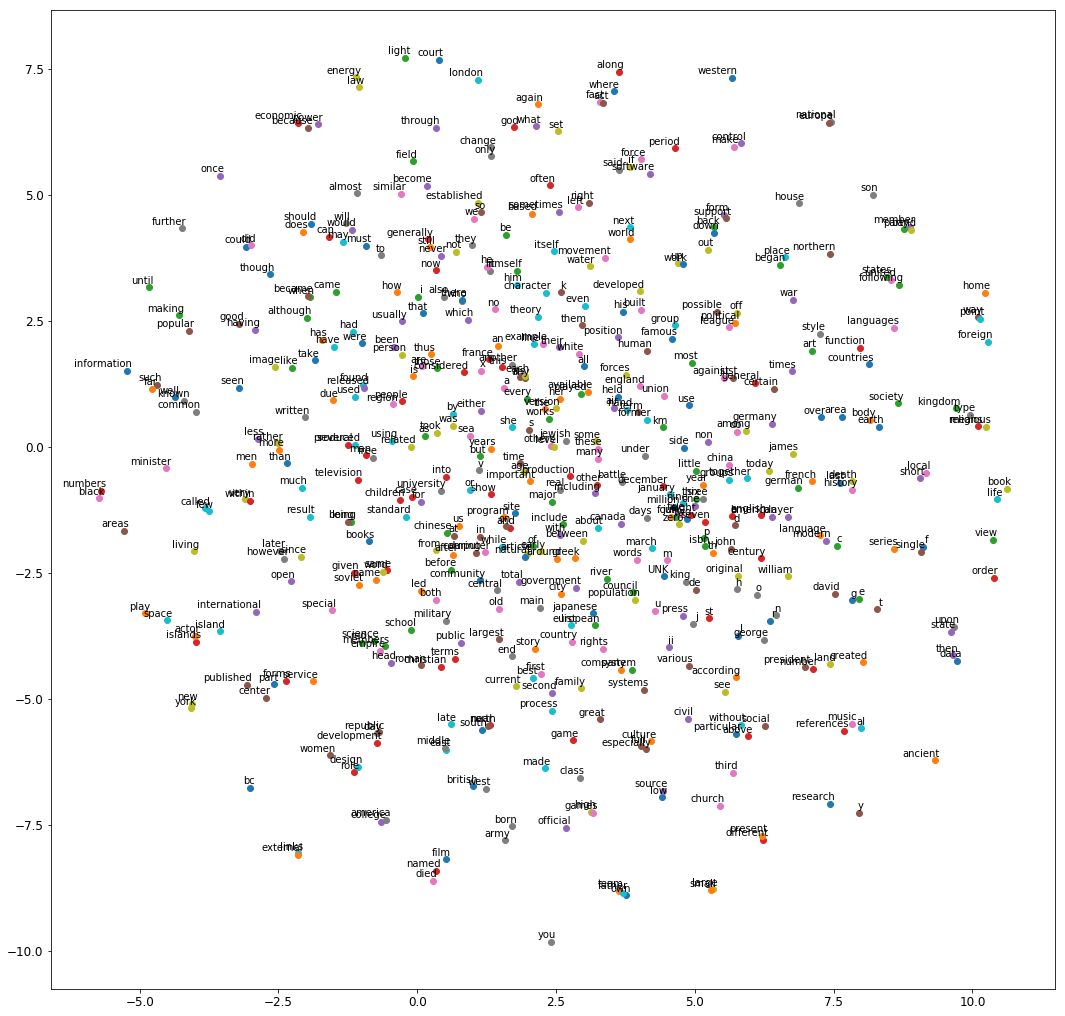

In [37]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [vocabulary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)

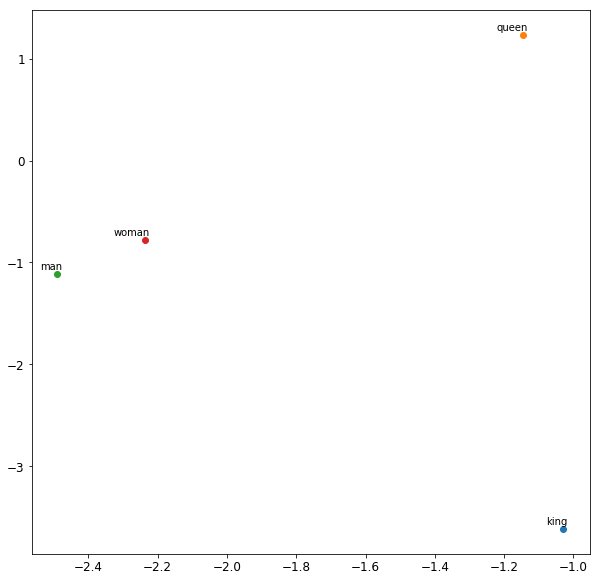

In [46]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
#labels = [vocabulary[i] for i in range(plot_only)]
labels = ['king','queen','man','woman']
plot_with_labels(low_dim_embs, labels)

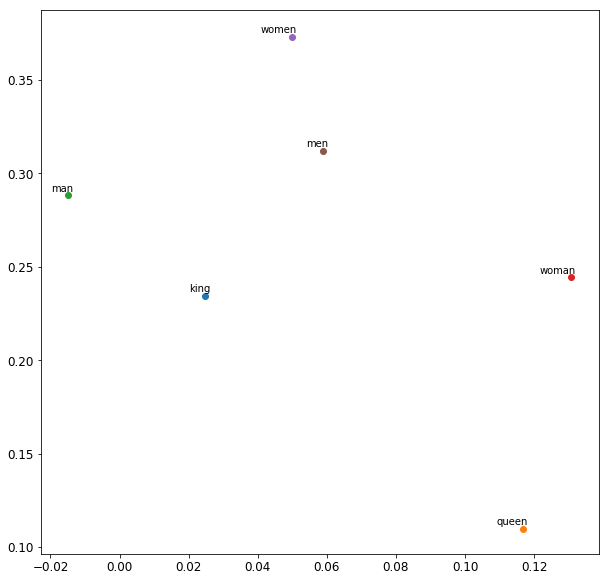

In [47]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(final_embeddings[:plot_only,:])
low_dim_embs = pca.transform(final_embeddings[:plot_only,:])
labels = ['king','queen','man','woman','women','men']
plot_with_labels(low_dim_embs, labels)

# Machine Translation

The `basic_rnn_seq2seq()` function creates a simple Encoder/Decoder model: it first runs an RNN to encode `encoder_inputs` into a state vector, then runs a decoder initialized with the last encoder state on `decoder_inputs`. Encoder and decoder use the same RNN cell type but they don't share parameters.

In [ ]:
import tensorflow as tf
reset_graph()

n_steps = 50
n_neurons = 200
n_layers = 3
num_encoder_symbols = 20000
num_decoder_symbols = 20000
embedding_size = 150
learning_rate = 0.01

X = tf.placeholder(tf.int32, [None, n_steps]) # English sentences
Y = tf.placeholder(tf.int32, [None, n_steps]) # French translations
W = tf.placeholder(tf.float32, [None, n_steps - 1, 1])
Y_input = Y[:, :-1]
Y_target = Y[:, 1:]

encoder_inputs = tf.unstack(tf.transpose(X)) # list of 1D tensors
decoder_inputs = tf.unstack(tf.transpose(Y_input)) # list of 1D tensors

lstm_cells = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
              for layer in range(n_layers)]
cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

output_seqs, states = tf.contrib.legacy_seq2seq.embedding_rnn_seq2seq(
    encoder_inputs,
    decoder_inputs,
    cell,
    num_encoder_symbols,
    num_decoder_symbols,
    embedding_size)

logits = tf.transpose(tf.unstack(output_seqs), perm=[1, 0, 2])

In [ ]:
logits_flat = tf.reshape(logits, [-1, num_decoder_symbols])
Y_target_flat = tf.reshape(Y_target, [-1])
W_flat = tf.reshape(W, [-1])
xentropy = W_flat * tf.nn.sparse_softmax_cross_entropy_with_logits(labels=Y_target_flat, logits=logits_flat)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

# Exercise solutions

## 1. to 6.

See Appendix A.

## 7. Embedded Reber Grammars

First we need to build a function that generates strings based on a grammar. The grammar will be represented as a list of possible transitions for each state. A transition specifies the string to output (or a grammar to generate it) and the next state.

In [ ]:
from random import choice, seed

# to make this notebook's output stable across runs
seed(42)
np.random.seed(42)

default_reber_grammar = [
    [("B", 1)],           # (state 0) =B=>(state 1)
    [("T", 2), ("P", 3)], # (state 1) =T=>(state 2) or =P=>(state 3)
    [("S", 2), ("X", 4)], # (state 2) =S=>(state 2) or =X=>(state 4)
    [("T", 3), ("V", 5)], # and so on...
    [("X", 3), ("S", 6)],
    [("P", 4), ("V", 6)],
    [("E", None)]]        # (state 6) =E=>(terminal state)

embedded_reber_grammar = [
    [("B", 1)],
    [("T", 2), ("P", 3)],
    [(default_reber_grammar, 4)],
    [(default_reber_grammar, 5)],
    [("T", 6)],
    [("P", 6)],
    [("E", None)]]

def generate_string(grammar):
    state = 0
    output = []
    while state is not None:
        production, state = choice(grammar[state])
        if isinstance(production, list):
            production = generate_string(grammar=production)
        output.append(production)
    return "".join(output)

Let's generate a few strings based on the default Reber grammar:

In [ ]:
for _ in range(25):
    print(generate_string(default_reber_grammar), end=" ")

Looks good. Now let's generate a few strings based on the embedded Reber grammar:

In [ ]:
for _ in range(25):
    print(generate_string(embedded_reber_grammar), end=" ")

Okay, now we need a function to generate strings that do not respect the grammar. We could generate a random string, but the task would be a bit too easy, so instead we will generate a string that respects the grammar, and we will corrupt it by changing just one character:

In [ ]:
def generate_corrupted_string(grammar, chars="BEPSTVX"):
    good_string = generate_string(grammar)
    index = np.random.randint(len(good_string))
    good_char = good_string[index]
    bad_char = choice(list(set(chars) - set(good_char)))
    return good_string[:index] + bad_char + good_string[index + 1:]

Let's look at a few corrupted strings:

In [ ]:
for _ in range(25):
    print(generate_corrupted_string(embedded_reber_grammar), end=" ")

It's not possible to feed a string directly to an RNN: we need to convert it to a sequence of vectors, first. Each vector will represent a single letter, using a one-hot encoding. For example, the letter "B" will be represented as the vector `[1, 0, 0, 0, 0, 0, 0]`, the letter E will be represented as `[0, 1, 0, 0, 0, 0, 0]` and so on. Let's write a function that converts a string to a sequence of such one-hot vectors. Note that if the string is shorted than `n_steps`, it will be padded with zero vectors (later, we will tell TensorFlow how long each string actually is using the `sequence_length` parameter).

In [ ]:
def string_to_one_hot_vectors(string, n_steps, chars="BEPSTVX"):
    char_to_index = {char: index for index, char in enumerate(chars)}
    output = np.zeros((n_steps, len(chars)), dtype=np.int32)
    for index, char in enumerate(string):
        output[index, char_to_index[char]] = 1.
    return output

In [ ]:
string_to_one_hot_vectors("BTBTXSETE", 12)

We can now generate the dataset, with 50% good strings, and 50% bad strings:

In [ ]:
def generate_dataset(size):
    good_strings = [generate_string(embedded_reber_grammar)
                    for _ in range(size // 2)]
    bad_strings = [generate_corrupted_string(embedded_reber_grammar)
                   for _ in range(size - size // 2)]
    all_strings = good_strings + bad_strings
    n_steps = max([len(string) for string in all_strings])
    X = np.array([string_to_one_hot_vectors(string, n_steps)
                  for string in all_strings])
    seq_length = np.array([len(string) for string in all_strings])
    y = np.array([[1] for _ in range(len(good_strings))] +
                 [[0] for _ in range(len(bad_strings))])
    rnd_idx = np.random.permutation(size)
    return X[rnd_idx], seq_length[rnd_idx], y[rnd_idx]

In [ ]:
X_train, l_train, y_train = generate_dataset(10000)

Let's take a look at the first training instances:

In [ ]:
X_train[0]

It's padded with a lot of zeros because the longest string in the dataset is that long. How long is this particular string?

In [ ]:
l_train[0]

What class is it?

In [ ]:
y_train[0]

Perfect! We are ready to create the RNN to identify good strings. We build a sequence classifier very similar to the one we built earlier to classify MNIST images, with two main differences:
* First, the input strings have variable length, so we need to specify the `sequence_length` when calling the `dynamic_rnn()` function.
* Second, this is a binary classifier, so we only need one output neuron that will output, for each input string, the estimated log probability that it is a good string. For multiclass classification, we used `sparse_softmax_cross_entropy_with_logits()` but for binary classification we use `sigmoid_cross_entropy_with_logits()`.


In [ ]:
reset_graph()

possible_chars = "BEPSTVX"
n_inputs = len(possible_chars)
n_neurons = 30
n_outputs = 1

learning_rate = 0.02
momentum = 0.95

X = tf.placeholder(tf.float32, [None, None, n_inputs], name="X")
seq_length = tf.placeholder(tf.int32, [None], name="seq_length")
y = tf.placeholder(tf.float32, [None, 1], name="y")

gru_cell = tf.contrib.rnn.GRUCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(gru_cell, X, dtype=tf.float32,
                                    sequence_length=seq_length)

logits = tf.layers.dense(states, n_outputs, name="logits")
y_pred = tf.cast(tf.greater(logits, 0.), tf.float32, name="y_pred")
y_proba = tf.nn.sigmoid(logits, name="y_proba")

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=momentum,
                                       use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.equal(y_pred, y, name="correct")
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Now let's generate a validation set so we can track progress during training:

In [ ]:
X_val, l_val, y_val = generate_dataset(5000)

In [ ]:
n_epochs = 50
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        X_batches = np.array_split(X_train, len(X_train) // batch_size)
        l_batches = np.array_split(l_train, len(l_train) // batch_size)
        y_batches = np.array_split(y_train, len(y_train) // batch_size)
        for X_batch, l_batch, y_batch in zip(X_batches, l_batches, y_batches):
            loss_val, _ = sess.run(
                [loss, training_op],
                feed_dict={X: X_batch, seq_length: l_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, seq_length: l_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: X_val, seq_length: l_val, y: y_val})
        print("{:4d}  Train loss: {:.4f}, accuracy: {:.2f}%  Validation accuracy: {:.2f}%".format(
            epoch, loss_val, 100 * acc_train, 100 * acc_val))
        saver.save(sess, "my_reber_classifier")

Now let's test our RNN on two tricky strings: the first one is bad while the second one is good. They only differ by the second to last character. If the RNN gets this right, it shows that it managed to notice the pattern that the second letter should always be equal to the second to last letter. That requires a fairly long short-term memory (which is the reason why we used a GRU cell).

In [ ]:
test_strings = [
    "BPBTSSSSSSSSSSSSXXTTTTTVPXTTVPXTTTTTTTVPXVPXVPXTTTVVETE",
    "BPBTSSSSSSSSSSSSXXTTTTTVPXTTVPXTTTTTTTVPXVPXVPXTTTVVEPE"]
l_test = np.array([len(s) for s in test_strings])
max_length = l_test.max()
X_test = [string_to_one_hot_vectors(s, n_steps=max_length)
          for s in test_strings]

with tf.Session() as sess:
    saver.restore(sess, "my_reber_classifier")
    y_proba_val = y_proba.eval(feed_dict={X: X_test, seq_length: l_test})

print()
print("Estimated probability that these are Reber strings:")
for index, string in enumerate(test_strings):
    print("{}: {:.2f}%".format(string, y_proba_val[index][0]))

Ta-da! It worked fine. The RNN found the correct answers with absolute confidence. :)

## 8. and 9.

Coming soon...